In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

file_path = 'JRFO_Table_NoNeg.csv'
data = pd.read_csv(file_path)

# Remove irrelevant columns
data_cleaned = data.drop(columns=['SW_in', 'SW_out', 'LW_in', 'LW_out'])
data_cleaned['TIMESTAMP'] = pd.to_datetime(data_cleaned['TIMESTAMP'])

# Extract features
data_cleaned['Year'] = data_cleaned['TIMESTAMP'].dt.year
data_cleaned['Month'] = data_cleaned['TIMESTAMP'].dt.month
data_cleaned['Day'] = data_cleaned['TIMESTAMP'].dt.day
data_cleaned['Hour'] = data_cleaned['TIMESTAMP'].dt.hour
data_cleaned['Minute'] = data_cleaned['TIMESTAMP'].dt.minute

data_cleaned['Hour_sin'] = np.sin(data_cleaned['Hour'] * (2. * np.pi / 24))
data_cleaned['Hour_cos'] = np.cos(data_cleaned['Hour'] * (2. * np.pi / 24))
data_cleaned['Month_sin'] = np.sin((data_cleaned['Month'] - 1) * (2. * np.pi / 12))
data_cleaned['Month_cos'] = np.cos((data_cleaned['Month'] - 1) * (2. * np.pi / 12))

data_cleaned = data_cleaned.drop(columns=['TIMESTAMP'])

# Remove nan columns
data_cleaned = data_cleaned.dropna(axis=1, how='any')
for column in data_cleaned.columns:
    data_cleaned[column] = pd.to_numeric(data_cleaned[column], errors='coerce')

# Remove rows with negative DBTCDT values
data_cleaned = data_cleaned[data_cleaned['DBTCDT'] >= 0]

print(data_cleaned.head())

   RECORD  Batt_volt_Min  PTemp  AirTC_Avg     RH       shf  Soil_Moisture  \
0       0          13.30 -1.644     -2.518  60.07 -19.77046          0.075   
1       1          13.26 -1.831     -2.668  66.46 -19.82511          0.075   
2       2          13.24 -2.071     -2.809  63.16 -19.91182          0.075   
3       3          13.18 -2.316     -3.037  65.16 -20.00223          0.075   
4       4          13.14 -2.564     -3.208  66.44 -20.09948          0.077   

   Soil_Temperature_C  Target_Depth  Qual  ...  DBTCDT  Year  Month  Day  \
0                 2.6         208.8     2  ...   4.011  2022     12    9   
1                 2.5         208.8     1  ...   4.075  2022     12    9   
2                 2.5         208.9     2  ...   4.025  2022     12    9   
3                 2.5         209.0     1  ...   3.953  2022     12    9   
4                 2.5         209.9     1  ...   3.135  2022     12    9   

   Hour  Minute  Hour_sin  Hour_cos  Month_sin  Month_cos  
0    15      2

Epoch 1/20
1327/1327 - 3s - loss: 386.6386 - val_loss: 260.7649 - 3s/epoch - 2ms/step
Epoch 2/20
1327/1327 - 2s - loss: 213.1298 - val_loss: 209.8465 - 2s/epoch - 1ms/step
Epoch 3/20
1327/1327 - 2s - loss: 176.8610 - val_loss: 166.7535 - 2s/epoch - 1ms/step
Epoch 4/20
1327/1327 - 2s - loss: 131.0334 - val_loss: 119.3427 - 2s/epoch - 1ms/step
Epoch 5/20
1327/1327 - 2s - loss: 99.7193 - val_loss: 89.2985 - 2s/epoch - 1ms/step
Epoch 6/20
1327/1327 - 2s - loss: 73.5531 - val_loss: 69.7859 - 2s/epoch - 1ms/step
Epoch 7/20
1327/1327 - 2s - loss: 51.2713 - val_loss: 43.1598 - 2s/epoch - 1ms/step
Epoch 8/20
1327/1327 - 2s - loss: 39.0381 - val_loss: 31.8118 - 2s/epoch - 1ms/step
Epoch 9/20
1327/1327 - 2s - loss: 27.7143 - val_loss: 19.3724 - 2s/epoch - 1ms/step
Epoch 10/20
1327/1327 - 2s - loss: 21.4726 - val_loss: 14.1388 - 2s/epoch - 1ms/step
Epoch 11/20
1327/1327 - 2s - loss: 15.4496 - val_loss: 8.0748 - 2s/epoch - 1ms/step
Epoch 12/20
1327/1327 - 2s - loss: 11.5487 - val_loss: 11.8801 - 2s

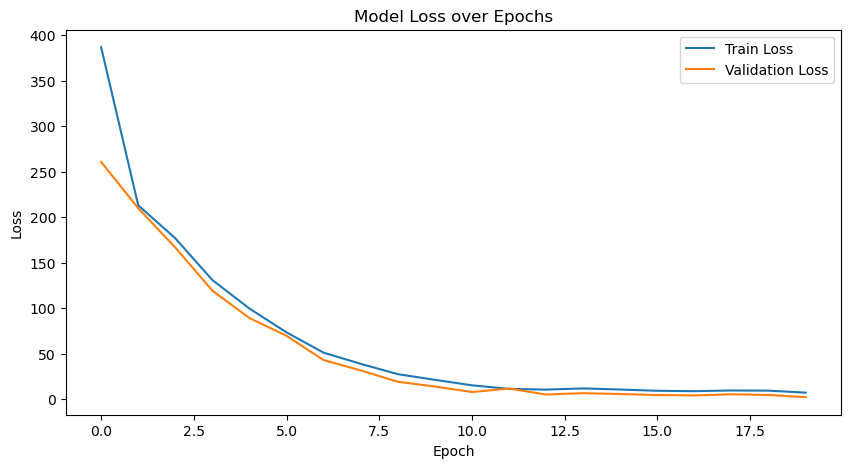

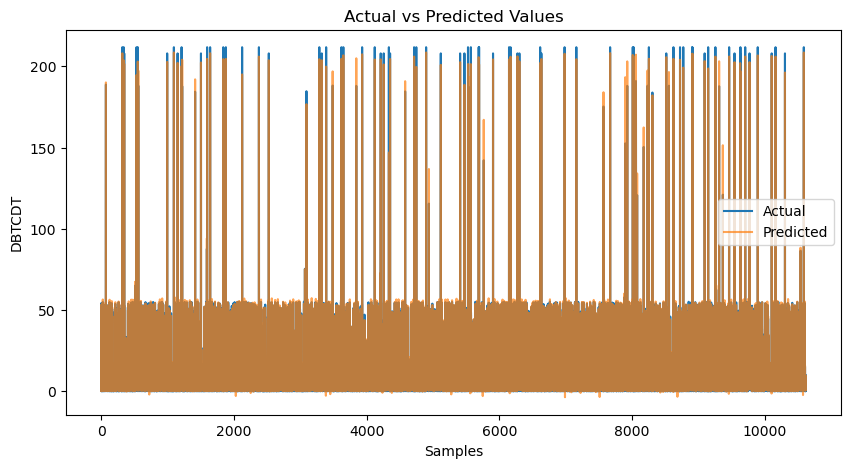

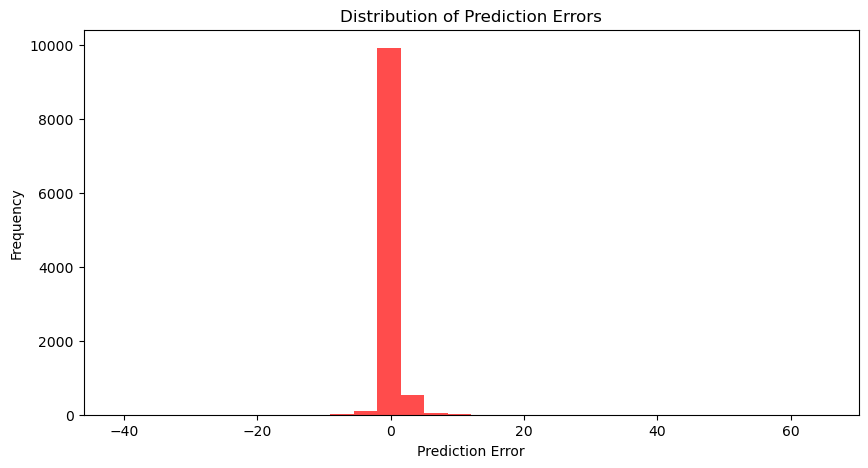

In [8]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
import numpy as np

features = data_cleaned.drop(columns=['RECORD', 'DBTCDT'])
target = data_cleaned['DBTCDT'].values

# Scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_scaled = np.reshape(features_scaled, (features_scaled.shape[0], 1, features_scaled.shape[1]))

X_train, X_val, y_train, y_val = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=2)

y_pred = model.predict(X_val)

# Calculate RMSE and R^2
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print("RMSE: ", rmse)
print("R^2 Score: ", r2)

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot Actual vs Predicted Values
plt.figure(figsize=(10, 5))
plt.plot(y_val, label='Actual')
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Values')
plt.xlabel('Samples')
plt.ylabel('DBTCDT')
plt.legend()
plt.show()

# Plot Error Distribution of Residuals
residuals = y_val - y_pred.flatten()
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30, alpha=0.7, color='red')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()